In [2]:
import numpy as np
import pandas as pd
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests 
import time

from selenium import webdriver 
from selenium.webdriver.common.keys import Keys 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from geopy.geocoders import Nominatim
import ast

import warnings
warnings.filterwarnings("ignore")

from my_functions import *

# **1. Merge ``df_masters`` & ``df_ratings``**

In [33]:
# import the dataframes
df_uk_masters = pd.read_csv('Datasets/df_uk_masters.csv')                         # all the albums from the UK
df_us_masters = pd.read_csv('Datasets/df_us_masters.csv')                         # albums from the US until 1996, 1998 and 2000
df_us_new_masters = pd.read_csv('Datasets/df_us_new_masters.csv')                         # albums from the US from 1997, 1999 and 2001
df_ratings_20 = pd.read_csv('Datasets/df_ratings_20.csv', keep_default_na=False)  # albums with >= 20 votes, mostly from rock, worldwide
df_masters_blended = pd.read_csv('Datasets/df_masters_blended.csv')               # albums from the UK and US (and others) with >= 10 votes 

# print information
print(f'{df_uk_masters.shape}: df_uk_masters')
print(f'{df_us_masters.shape}: df_us_masters')
print(f'{df_us_new_masters.shape}: df_us_new_masters')
print(f'{df_ratings_20.shape}: df_ratings_20')
print(f'{df_masters_blended.shape}: df_masters_blended')

(56660, 13): df_uk_masters
(48690, 13): df_us_masters
(3641, 13): df_us_new_masters
(51222, 5): df_ratings_20
(11920, 13): df_masters_blended


In [7]:
df_uk_masters['master_id'].isna().sum()

0

In [ ]:
df_uk_masters['master_id'].fillna(0, inplace=True)
df_uk_masters['master_id'].isna().sum()

0

## **Concat with the albums previously cleaned**

In [4]:
df_us_2001 = pd.read_csv('Datasets/df_us_2001.csv')
df_us_2001.shape

(786, 13)

In [7]:
df_us_2001['styles'].value_counts().head(10)

styles
['Alternative Rock']                              243
['Alternative Rock', 'Indie Rock']                 44
['Alternative Rock', 'Grunge', 'Classic Rock']     37
['Alternative Rock', 'Pop Rock']                   22
['Alternative Rock', 'Hard Rock']                  21
['Alternative Rock', 'Grunge']                     17
['Alternative Rock', 'Country Rock']               17
['Punk']                                           14
['Indie Rock', 'Alternative Rock']                 13
[]                                                  9
Name: count, dtype: int64

In [25]:
df_concat = pd.concat([df_us_new_masters, df_us_2001])
df_concat.shape

(3643, 13)

In [26]:
check_duplicates(df_concat)

2

<Axes: xlabel='count', ylabel='year'>

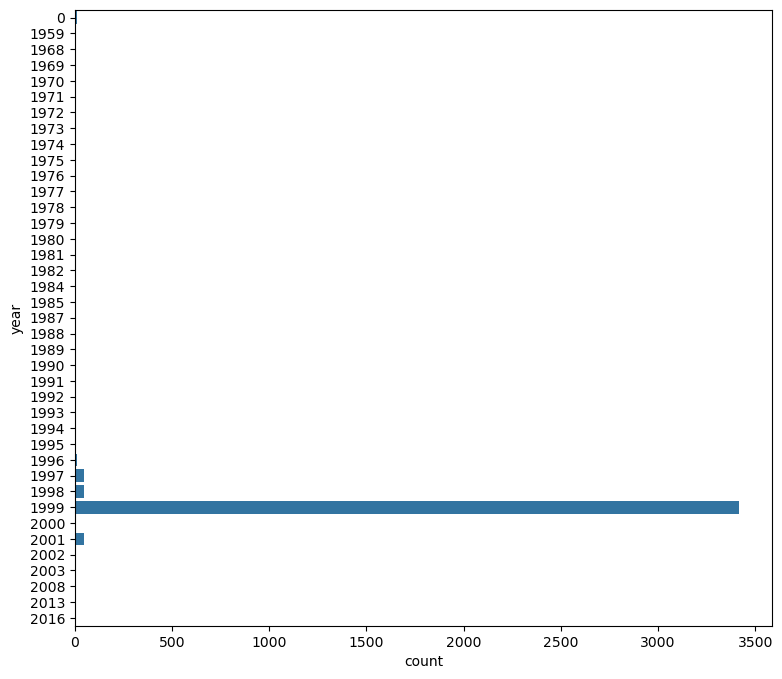

In [ ]:
# make sure most of the albums are from the year I theoretically just got
plt.figure(figsize=(9,8))
sns.countplot(data=df_concat, y='year')

**Export to csv**

In [28]:
df_concat.to_csv('Datasets/df_us_new_masters.csv', index=False)

In [19]:
df_masters = df_concat

## **``df_masters`` parenthesis cleaning from ``artist``**

### Testing

I noticed that some artists in df_masters (so, in the Discogs API) have numbers in parenthesis in the artist name, which won't be merged with df_ratings, where there are almost no artists with numbers in parenthesis

In [59]:
# all the artists in df_masters
df_masters['artist'].nunique()

27045

In [60]:
# show the artists that have characters in parenthesis in the artist name
df_masters_parenthesis = df_masters[df_masters['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_masters_parenthesis['artist'].nunique()

4816

In [34]:
# print information
print(f'{df_masters.shape}: df_masters')
print(f'{df_masters_parenthesis.shape}: df_masters_parenthesis')

(15584, 13): df_masters
(656, 13): df_masters_parenthesis


In [ ]:
df_ratings_10['artist'].nunique()

23683

In [ ]:
# show the artists that have characters in parenthesis in the artist name
df_ratings_10_parenthesis = df_ratings_10[df_ratings_10['artist'].str.contains(r'\(.*?\)', regex=True)].sort_values('artist')
df_ratings_10_parenthesis['artist'].nunique()

0

In [ ]:
# print information
print(f'{df_ratings_10.shape}: df_ratings_10')
print(f'{df_ratings_10_parenthesis.shape}: df_ratings_10_parenthesis')

(79632, 5): df_ratings_top
(1760, 5): df_ratings_top_parenthesis


In [ ]:
df_ratings_10_parenthesis.sample(5)

,album_id,artist,title,rating,votes
66859,299052,Vacations (AUS),Vibes and Days,3.87,15
66521,293448,Carnation (BE),Chapel of Abhorrence,3.35,40
34007,67551,Soundtrack (Video Game),The Legend of Zelda: Twilight Princess OST,4.23,80
39072,84542,Doom (JPN),Complicated Mind,4.16,25
36362,74638,Tempest (Can),Passages,3.73,37


In most of the artists, the information between parenthesis is the country of origin

In [39]:
# delete these characters
df_masters_parenthesis_clean = df_masters_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_masters_parenthesis_clean

2364       100% Proof
3971       100% Proof
2622     20/20 Vision
1164       38 Special
2445       38 Special
            ...      
3727              XIT
3045            Ya Ya
1735    Youth In Asia
3931              ZED
599              Zeno
Name: artist, Length: 656, dtype: object

In [ ]:
# delete these characters
df_ratings_10_parenthesis_clean = df_ratings_10_parenthesis['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
df_ratings_10_parenthesis_clean

52533                  
53599                  
35534    Slowest Runner
35487    Slowest Runner
13266              p.e.
              ...      
39716              hide
68464              life
70926              life
49438              sway
68857              オオハシ
Name: artist, Length: 1760, dtype: object

In [ ]:
# merge test, all the artists that coincide on both dataframes after the parenthesis cleaning
pd.merge(df_masters_parenthesis_clean, df_ratings_10_parenthesis_clean, on='artist')

,artist
0,Alaska
1,Alaska
2,Alaska
3,Alaska
4,Attila
...,...
123,X
124,X
125,X
126,X


In [45]:
df_masters[df_masters['artist'].str.contains('Alaska ')]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1516,594810.0,309057.0,2702245,US,Alaska (8),The Pack,1985,42.32,9,"['LP', 'Album', 'Stereo']",['Rock'],['Hard Rock'],Alaska was a British hard rock band led by Ber...
2990,594810.0,591189.0,1175493,UK,Alaska (8),Heart Of The Storm,1984,0.00,10,"['LP', 'Album']",['Rock'],"['Hard Rock', 'AOR']",Alaska was a British hard rock band led by Ber...


In [ ]:
df_ratings_10[df_ratings_10['artist'].str.contains('Alaska ')]

,album_id,artist,title,rating,votes
48864,135438,Alaska (USA),Everything is Fine,3.38,12
57915,203926,Alaska (USA),Shrine,3.54,12


This shows that for instance **the artist 'Zebra' would not have merged** if we hadn't done that cleaning, because in ``df_masters`` it's registered under **"Zebra (8)"**, and in ``df_ratings`` under **"Zebra (US)"**

### **Let's change the ``artist`` column for good**

In [20]:
df_masters.shape

(104518, 13)

In [21]:
df_masters['artist'] = df_masters['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_masters['artist'].nunique()} unique artists in df_masters")

54580 unique artists in df_masters


In [22]:
df_ratings_10['artist'] = df_ratings_10['artist'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

print(f"{df_ratings_10['artist'].nunique()} unique artists in df_ratings_10")

23683 unique artists in df_ratings_10


## **&/and Cleaning**

I noticed some artist and/or album names are slightly different, which will cause the merge to not properly function as I intend it.

Notice the difference in the following album: "Behold **and/&** See"

In [23]:
df_ratings_10[df_ratings_10['artist']=="Ultimate Spinach"]

,album_id,artist,title,rating,votes
48951,136113,Ultimate Spinach,Ultimate Spinach,3.81,27
51039,150508,Ultimate Spinach,Behold and See,3.89,23


In [24]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1815,407733.0,124122.0,1972400,US,Ultimate Spinach,Ultimate Spinach,1968,36.28,9,"['LP', 'Album', 'Stereo']",['Rock'],"['Psychedelic Rock', 'Garage Rock']","American Psychedelic Rock Band from Boston, Ma..."
31348,407733.0,124123.0,1922050,US,Ultimate Spinach,Behold & See,1968,52.07,8,"['LP', 'Album', 'Stereo']",['Rock'],['Psychedelic Rock'],"American Psychedelic Rock Band from Boston, Ma..."
2441,407733.0,292196.0,1382596,US,Ultimate Spinach,Ultimate Spinach,1969,37.83,10,"['LP', 'Album']",['Rock'],['Psychedelic Rock'],"American Psychedelic Rock Band from Boston, Ma..."


In [25]:
df_masters[['artist', 'title']] = df_masters[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))
df_ratings_10[['artist', 'title']] = df_ratings_10[['artist', 'title']].apply(lambda x: x.str.replace('&', 'and'))

In [26]:
df_masters[df_masters['artist']=="Ultimate Spinach"]

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
1815,407733.0,124122.0,1972400,US,Ultimate Spinach,Ultimate Spinach,1968,36.28,9,"['LP', 'Album', 'Stereo']",['Rock'],"['Psychedelic Rock', 'Garage Rock']","American Psychedelic Rock Band from Boston, Ma..."
31348,407733.0,124123.0,1922050,US,Ultimate Spinach,Behold and See,1968,52.07,8,"['LP', 'Album', 'Stereo']",['Rock'],['Psychedelic Rock'],"American Psychedelic Rock Band from Boston, Ma..."
2441,407733.0,292196.0,1382596,US,Ultimate Spinach,Ultimate Spinach,1969,37.83,10,"['LP', 'Album']",['Rock'],['Psychedelic Rock'],"American Psychedelic Rock Band from Boston, Ma..."


## Actual merge

In [27]:
df = pd.merge(
    df_ratings_20.assign(artist_lower=df_ratings_20['artist'].str.lower().str.strip(), 
                      title_lower=df_ratings_20['title'].str.lower().str.strip()), 
    df_masters.assign(artist_lower=df_masters['artist'].str.lower().str.strip(), 
                      title_lower=df_masters['title'].str.lower().str.strip()), 
    on=['artist_lower', 'title_lower']
).drop(columns=['artist_lower', 'title_lower', 'artist_y', 'title_y'])

# Rename columns
df.rename(columns={'artist_x': 'artist', 'title_x': 'title'}, inplace=True)

# Change dtypes
df['master_id'] = df['master_id'].astype(int)

# print the shape
df.shape

(12463, 16)

In [28]:
df[df['artist']=='Bob Dylan and The Band']

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
1552,4473,Bob Dylan and The Band,The Basement Tapes,4.04,291,2754841.0,0,13774158,US,1975,76.93,24,"['LP', 'Album']",['Rock'],"['Folk Rock', 'Country Rock', 'Classic Rock']",NaN


In [29]:
df.sample(5)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
9574,108149,Nazareth,No Mean City,3.73,58,253882.0,24569,1454388,UK,1979,0.00,8,"['LP', 'Album']",['Rock'],['Art Rock'],Nazareth are a Scottish hard rock band formed ...
5621,25566,Coalesce,0:12 Revolution in Just Listening,3.95,389,337332.0,112931,520801,US,1999,23.77,9,['Album'],['Rock'],"['Metalcore', 'Math Rock']","Hardcore / metalcore band from Kansas City, US..."
10083,147672,The Fray,Helios,1.73,65,616311.0,656887,5426001,US,2014,42.38,11,"['LP', 'Album']",['Rock'],['Pop Rock'],"Soft rock band from Denver, Colorado. USA.\r\n..."
3794,13685,The Damned,Anything,2.64,38,152965.0,18718,1227274,UK,1986,41.00,9,"['LP', 'Album', 'Limited Edition', 'Special Ed...",['Rock'],"['New Wave', 'Punk']",English punk band formed in 1976 in London by ...
2747,8643,In the Woods...,Heart Of The Ages,3.99,217,206388.0,13598,3918054,UK,1995,59.17,7,['Album'],['Rock'],"['Black Metal', 'Doom Metal']",The Norwegian band started out in 1990 as a de...


In [30]:
df['release_country'].value_counts().head(10)

release_country
US                 5267
UK                 3248
Europe             1532
Germany             429
UK & Europe         389
Canada              228
UK, Europe & US     145
Australia           128
Worldwide           114
USA & Canada         99
Name: count, dtype: int64

In [32]:
print(f"{round(df.shape[0] / df_masters.shape[0]*100, 2)} % of the albums have more than 20 votes")

11.92 % of the albums have more than 20 votes


### First inspection

**Change the dtype of ``artist_id``**

In [56]:
df[df['artist_id'].isna()]

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile


In [53]:
df[df['artist']=='David Bowie'].sample(3)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
2206,7017,David Bowie,"""Heroes""",4.27,1702,10263.0,0,13020767,UK,1977,40.33,10,"['LP', 'Album']","['Electronic', 'Rock']",['Experimental'],"British pop/rock singer, musician, songwriter,..."
837,2031,David Bowie,Hunky Dory,4.35,1996,10263.0,0,15836400,UK,1971,41.07,11,"['LP', 'Album']",['Rock'],['Glam'],"British pop/rock singer, musician, songwriter,..."
3500,11719,David Bowie,Let's Dance,3.40,875,10263.0,48753,712084,UK,1983,39.68,8,"['LP', 'Album', 'Stereo']","['Rock', 'Funk / Soul', 'Pop']","['Pop Rock', 'Dance-pop', 'New Wave']","British pop/rock singer, musician, songwriter,..."


In [55]:
df.loc[7998, 'artist_id'] = 10263

In [57]:
df['artist_id'] = df['artist_id'].astype(int)
df.head(1)

,album_id,artist,title,rating,votes,artist_id,master_id,main_release_id,release_country,year,album_length,tracks,release_type,genres,styles,artist_profile
0,37,Less Than Jake,Losing Streak,3.9,414,253327,237762,404505,US,1996,37.08,17,['Album'],['Rock'],"['Ska', 'Punk']",Ska-influenced punk-rock band formed in Gaines...


**Sort columns**

I want to see the ``year`` next to the album ``title``, and I don't care much about the ``ids``

In [58]:
df = columns_show_ratings(df)
df.head(1)

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
0,37,Less Than Jake,Losing Streak,1996,3.9,414,37.08,17,US,['Album'],['Rock'],"['Ska', 'Punk']",Ska-influenced punk-rock band formed in Gaines...,253327,237762,404505


**I keep only rock albums**

In [ ]:
# how many of them are Rock albums?
print(f"Rows before dropping: {df.shape[0]}")
df = df[df['genres'].str.contains('Rock')]
print(f"Rows after dropping: {df.shape[0]}")

(12209, 16)

**Drop compilations**

In [61]:
df['release_type'].isna().sum()

2

In [67]:
df['release_type'].value_counts().head(10)

release_type
['Album']                             5206
['LP', 'Album']                       3246
['LP', 'Album', 'Stereo']             1315
['LP', 'Album', 'Limited Edition']     411
['Album', 'Stereo']                    314
['Album', 'Enhanced']                  174
['Album', 'Limited Edition']           139
['LP', 'Album', 'Mono']                117
['LP']                                  91
['FLAC', 'Album']                       78
Name: count, dtype: int64

In [63]:
df[df['release_type'].isna()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
1229,3415,3 Doors Down,Seventeen Days,2005,2.65,375,51.7,14,US,NaN,['Rock'],['Alternative Rock'],"Alternative Rock (Modern Rock) from Escatawpa,...",166483,89121,512748
8799,75222,Fireworks,Gospel,2011,3.85,331,0.0,12,US,NaN,['Rock'],"['Punk', 'Pop Rock']","American pop-punk band from Metro Detroit, Mic...",1922447,378800,4088584


In [65]:
df.loc[1230, 'release_type']

"['Album']"

In [73]:
df.loc[1229, 'release_type'] = 'Album'
df.loc[8799, 'release_type'] = 'Album'

In [74]:
df['release_type'].isna().sum()

0

In [75]:
print(df['release_type'].dtype)

object


In [76]:
type(df.release_type[0])

str

In [77]:
print(f'There are {df[df['release_type'].str.contains('Compilation')].shape[0]} compilations')

There are 53 compilations


In [ ]:
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['release_type'].str.contains('Compilation')]
print(f"Rows after dropping: {df.shape[0]}")

(12156, 16)

In [79]:
# number of unique artists
df['artist'].nunique()

4538

**YOB** té **8** albums a Sputnik (``df_ratings_20``), però nomes **2** a Discogs de UK, tot i que és una banda de UK. 

Si apareixen al df de US, hauré de fer un concat/merge

In [80]:
df[df['artist']=='YOB']

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
8157,60241,YOB,Catharsis,2003,3.99,140,49.07,3,US,['Album'],['Rock'],['Doom Metal'],Yob is an American stoner/doom metal band from...,563922,129480,2806549
10264,163668,YOB,Clearing The Path To Ascend,2014,3.92,331,62.53,4,US,['Album'],['Rock'],"['Doom Metal', 'Sludge Metal']",Yob is an American stoner/doom metal band from...,563922,729329,6054020


In [81]:
df_ratings_20[df_ratings_20['artist']=='YOB']

,album_id,artist,title,rating,votes
2485,3646,YOB,The Illusion Of Motion,3.94,183
15507,29146,YOB,The Unreal Never Lived,4.06,225
19335,39606,YOB,The Great Cessation,3.90,205
24401,60240,YOB,Elaborations Of Carbon,3.42,73
24402,60241,YOB,Catharsis,3.99,140
28092,80046,YOB,Atma,3.78,259
36277,163668,YOB,Clearing The Path To Ascend,3.92,331
43372,282109,YOB,Our Raw Heart,3.87,295


## **``df`` real cleaning**

I want to **drop duplicates** and releases from **bands outside of the UK and the US**, I only want to keep brittish and american artists. Also **drop compilations and live albums**.

### **Drop duplicates**

**``master_id = 0``**

In [343]:
df.sort_values('master_id', inplace=True, ascending=False) # so I keep the master_id=0 at the end, these would be the duplicates and I'll be able to drop them
df.reset_index(drop=True, inplace=True)
df[['album_id', 'artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks']].duplicated().sum()

0

In [84]:
# these albums are the same, except one entry has master_id=0
print(f"Rows before dropping: {df.shape[0]}")
df.drop_duplicates(subset=['artist', 'title', 'year', 'rating', 'votes', 'album_length', 'tracks'], inplace=True)
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 12099
Rows after dropping: 12099


**``album_length = 0``**

In [329]:
df.sort_values('album_length', inplace=True, ascending=False) # so I keep the album_length=0 at the end, these would be the duplicates and I'll be able to drop them
df.reset_index(drop=True, inplace=True)
df[['album_id', 'artist', 'title', 'year', 'rating', 'votes']].duplicated().sum()

26

In [335]:
df[df[['album_id', 'artist', 'title', 'year', 'rating', 'votes']].duplicated()]['album_length'].value_counts()

album_length
0.00     17
76.15     1
46.62     1
45.02     1
42.18     1
39.75     1
37.82     1
36.98     1
36.40     1
18.95     1
Name: count, dtype: int64

In [336]:
# most of these albums are the same, except one entry has album_length=0
print(f"Rows before dropping: {df.shape[0]}")
df.drop_duplicates(subset=['artist', 'title', 'year', 'rating', 'votes'], inplace=True)
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 12061
Rows after dropping: 12035


**duplicates by ``artist`` and ``title``**

In [475]:
df[df[['artist', 'title']].duplicated()].head()

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id


In [476]:
df[['artist', 'title']].duplicated().sum()

0

In [473]:
df[df['title']=='Beat the Bastards	'.strip()]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
8215,15882,The Exploited,Beat the Bastards,1996,3.64,74,51.57,13,UK,['Album'],['Rock'],['Punk'],"Punk hardcore thrash band from Edinburgh, Scot...",262795,53295,498617
12027,15882,The Exploited,Beat the Bastards,1983,3.64,74,0.00,24,UK,"['Album', 'Unofficial Release', 'Stereo']",['Rock'],['Punk'],"Punk hardcore thrash band from Edinburgh, Scot...",262795,0,29731594


**Drop incorrect albums**

In [474]:
# check one by one if necessary
try:
    df.drop([12027], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(12004, 16)


**Change specific values that are wrong/missing**

In [454]:
# change specific values that are wrong/missing

# df.loc[9591, 'title'] = 'Santana III'
# df.loc[9591, 'rating'] = 4.26
# df.loc[9591, 'votes'] = 227
df.loc[4695, 'album_length'] = 30.25
# df.loc[3286, 'tracks'] = 15
# df.loc[9575, 'year'] = 1996

In [404]:
# calculate the decimals of the album length (seconds)
29/60

0.48333333333333334

**``df_ratings_top``**

If there are two albums with the same name, but one is for instance an EP or a compilation I don't want to keep, I have to drop it from df,

but also from ``df_ratings_top``, otherwise I will keep running into this duplicated album every time I add more albums

In [462]:
df_ratings_20[df_ratings_20['artist']=='Pepper'.strip()]

,album_id,artist,title,rating,votes
2436,3581,Pepper,Kona Town,3.87,114
2708,3970,Pepper,In With The Old,3.46,61
8649,14537,Pepper,No Shame,3.34,79
15291,28637,Pepper,Pink Crustaceans and Good Vibrations,3.26,40
16813,32335,Pepper,Give'n It,3.22,20
33650,130639,Pepper,Pepper,2.52,21


In [419]:
# check one by one if necessary
try:
    df_ratings_20.drop([4051], axis=0, inplace=True)
    print('Rows dropped')
    print(df_ratings_20.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(51240, 5)


In [477]:
df_ratings_20.to_csv('Datasets/df_ratings_20.csv', index=False)

### **Drop live albums**

**Hauré d'eliminar tmb albums de 'MTV Unplugged'**

Let's try to detect the live albums by the title

#### **'Live at'**

In [478]:
df.shape

(12004, 16)

In [479]:
print(f"There are {df[df['title'].str.contains('Live at ', case=False)].shape[0]} albums with 'Live at ' in the title")

There are 24 albums with 'Live at ' in the title


In [480]:
# Let's check them before deleting them
df[df['title'].str.contains('Live at ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
505,413051,Anna von Hausswolff,Live at Montreux Jazz Festival,2022,4.27,43,59.63,6,"UK, Europe & US",['Album'],"['Rock', 'Classical']",[],"Swedish singer, pianist, organist and songwrit...",1724854,2470054,21778390
877,341452,IDLES,A Beautiful Thing: Idles Live At Le Bataclan,2019,4.15,24,0.00,21,Worldwide,['Album'],['Rock'],"['Punk', 'Post-Punk']","British heavy indie/punk band from Bristol, Lo...",2890530,1645355,14475294
1597,238704,Bring Me The Horizon,Live at the Royal Albert Hall,2016,3.89,91,0.00,15,Europe,"['Album', 'Limited Edition']",['Rock'],"['Symphonic Rock', 'Post-Hardcore']","Metalcore band from Sheffield, Yorkshire, UK, ...",1253307,1105195,9480833
2159,182112,King Crimson,Live at the Orpheum,2015,3.38,21,81.87,14,"UK, Europe & US",['Album'],['Rock'],"['Prog Rock', 'Art Rock']",were an English-based progressive rock band fo...,70828,784639,6528463
2252,168442,Queen,Live at the Rainbow '74,2014,4.52,42,144.15,43,Europe,['Album'],['Rock'],[],Queen is a British rock band formed in London ...,81013,729723,6058985
2826,46328,Derek and the Dominos,Live at the Fillmore,1994,3.89,22,122.02,13,US,"['Album', 'Remastered']","['Rock', 'Blues']","['Blues Rock', 'Electric Blues', 'Classic Rock']",Blues rock band formed in the spring of 1970 a...,110252,522124,10681728
3165,72449,Iron Maiden,Live At The Rainbow,1981,4.22,38,0.00,7,UK,"['Stereo', 'PAL']",['Rock'],['Heavy Metal'],"English heavy metal band formed in Leyton, Eas...",251595,435450,2181680
3656,79170,Biffy Clyro,Revolutions // Live At Wembley,2011,3.99,60,103.65,53,UK,['Album'],['Rock'],"['Power Pop', 'Indie Rock']",Biffy Clyro are a mainstream rock band which f...,269159,350353,2965167
3724,1119,Faith No More,Live at the Brixton Academy,1991,3.68,155,50.97,10,UK,['Album'],['Rock'],"['Alternative Rock', 'Funk Metal']","An American rock band from San Francisco, Cali...",12937,339044,3396126
4057,50550,The Who,Live at the Isle of Wight Festival 1970,1996,4.42,52,112.35,30,Europe,['Album'],"['Rock', 'Blues']","['Hard Rock', 'Rhythm & Blues', 'Rock & Roll']","English rock band formed in Hammersmith, Londo...",196766,296116,1283897


In [ ]:
# correct, they are all live albums
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains('Live at ', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

(11980, 16)

#### **'Live in'**

In [482]:
print(f"There are {df[df['title'].str.contains(r'^Live in ', case=False)].shape[0]} albums with 'Live in ' in the title")

There are 6 albums with 'Live in ' in the title


In [ ]:
# Let's check them before deleting them
df[df['title'].str.contains(r'^Live in ', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
2646,42478,Panic! at the Disco,...Live in Chicago,2008,3.21,59,72.32,27,Europe,[],['Rock'],"['Pop Punk', 'Pop Rock']","American rock band from Las Vegas, Nevada. US\...",553643,573038,3477215


In [492]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r'^...Live in ', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 11974
Rows after dropping: 11973


In [493]:
# This is a studio album
df[df['title'].str.contains('Live in ', case=True)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
4759,16841,Low,I Could Live in Hope,1994,4.12,533,57.08,11,US,['Album'],['Rock'],['Slowcore'],"American indie rock group from Duluth, Minneso...",10824,225930,545527


#### **'MTV Unplugged'**

In [495]:
print(f"There are {df[df['title'].str.contains(r'MTV Unplugged', case=False)].shape[0]} albums with 'MTV Unplugged' in the title")

There are 6 albums with 'MTV Unplugged' in the title


In [496]:
# Let's check them before deleting them
df[df['title'].str.contains(r'MTV Unplugged', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
1270,114818,Pearl Jam,MTV Unplugged,2019,4.47,82,0.00,7,US,"['LP', 'Album', 'Record Store Day']",['Rock'],"['Alternative Rock', 'Grunge', 'Acoustic']",Alternative Rock (Modern Rock) band from Seatt...,175395,1330087,14464021
3730,23071,Shakira,MTV Unplugged,2000,3.48,24,50.58,11,Europe,['Album'],"['Rock', 'Latin', 'Pop']","['Pop Rock', 'Latin Pop']","Shakira Isabel Mebarak Ripoll, professionally ...",5530,337798,915209
4968,4490,Bob Dylan,MTV Unplugged,1995,3.35,71,69.32,12,Europe,['Album'],['Rock'],['Folk Rock'],"Born: May 24, 1941, Duluth, Minnesota, USA; si...",59792,206974,676331
9863,14071,Alanis Morissette,MTV Unplugged,1999,3.88,42,53.73,12,US,['Album'],"['Rock', 'Pop']","['Alternative Rock', 'Acoustic', 'Pop Rock']","Canadian singer born on June 1, 1974 in Ottawa...",102789,28707,1464025
10347,465,Nirvana,MTV Unplugged in New York,1994,4.38,2138,53.93,14,US,['Album'],['Rock'],"['Folk Rock', 'Acoustic', 'Grunge']","Rock band from Aberdeen, Washington, USA, form...",125246,22433,375980
10385,2122,Alice in Chains,MTV Unplugged,1996,4.34,1196,71.43,13,US,['Album'],['Rock'],"['Alternative Rock', 'Acoustic', 'Grunge']",Alternative Rock (Modern Rock) band formed in...,251846,21706,367637


In [497]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r'MTV Unplugged', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 11973
Rows after dropping: 11967


### **Dropping compilations sorting albums by the top rated**

#### **'Greatest Hits'**

In [499]:
print(f"There are {df[df['title'].str.contains(r'Greatest Hits', case=False)].shape[0]} albums with 'Greatest Hits' in the title")

There are 2 albums with 'Greatest Hits' in the title


In [500]:
# Let's check them before deleting them
df[df['title'].str.contains(r'Greatest Hits', case=False)]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
619,397420,Waterparks,Greatest Hits,2021,1.90,29,0.00,17,US,"['LP', 'Album']","['Rock', 'Pop']","['Pop Punk', 'Pop Rock', 'Alternative Rock']",NaN,5148547,2136826,18820930
8989,7616,Ramones,Greatest Hits Live,1996,3.48,42,37.65,19,US,['Album'],['Rock'],['Punk'],USA punk rock band formed in 1974 and disbande...,135478,39437,561419


In [501]:
# I can drop them all
print(f"Rows before dropping: {df.shape[0]}")
df = df[~df['title'].str.contains(r'Greatest Hits', case=False)]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 11967
Rows after dropping: 11965


#### **Sorting by the top rated and most rated**

Usually compilations have the best songs of the band and users love them, so let's find them, even if 'Compilation' is not in ``release_type``

In [565]:
start_row = 50

df.sort_values(['rating', 'votes'], ascending=False).iloc[start_row:start_row+10]

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
9070,65469,Neil Young,Weld,1991,4.43,79,116.53,16,Europe,"['LP', 'Album', 'Stereo']",['Rock'],"['Country Rock', 'Grunge', 'Classic Rock', 'Ha...",Neil Young is a Canadian-American singer-songw...,138556,38782,1271036
11450,222,Metallica,Ride The Lightning,1984,4.42,8013,47.33,8,US,"['LP', 'Album']",['Rock'],"['Thrash', 'Speed Metal']",Thrash Metal (Heavy Metal) band from Los Angel...,18839,6440,377464
10558,221,Iron Maiden,The Number Of The Beast,1982,4.42,4682,39.18,8,UK,"['LP', 'Album', 'Stereo']",['Rock'],['Heavy Metal'],"English heavy metal band formed in Leyton, Eas...",251595,18742,1466299
10698,243,Pixies,Doolittle,1989,4.42,3247,38.62,15,UK,"['LP', 'Album', 'Limited Edition']",['Rock'],['Indie Rock'],US alternative rock band formed in early 1986 ...,231577,16764,2805906
11237,504,Jeff Buckley,Grace,1994,4.42,2165,51.77,10,US,"['Album', 'Stereo']",['Rock'],"['Alternative Rock', 'Folk Rock']","Jeffrey Scott Buckley (November 17, 1966 - May...",159169,9298,8767620
9138,556,The Stooges,Fun House,1970,4.42,1319,36.47,7,US,"['LP', 'Album', 'Stereo']",['Rock'],"['Punk', 'Hard Rock', 'Experimental', 'Garage ...",U.S. garage rock / heavy psychedelic / proto p...,39770,38209,1352562
6196,1016,Led Zeppelin,How The West Was Won,2003,4.42,585,150.32,18,Europe,['Album'],['Rock'],"['Hard Rock', 'Classic Rock', 'Blues Rock']",The English rock band Led Zeppelin was active ...,34278,115931,1794547
9447,70532,Sting,Bring on the Night,1986,4.42,20,82.73,13,UK,"['LP', 'Album', 'Stereo']","['Jazz', 'Rock']","['Jazz-Rock', 'Pop Rock', 'Fusion']","Musician (bassist), composer, singer-songwrite...",13961,33618,758792
8581,1640,At the Drive-In,Relationship of Command,2000,4.41,4560,45.32,11,US,['Album'],['Rock'],"['Post-Hardcore', 'Indie Rock']","Band from El Paso, TX, formed in 1993. Flipsid...",81742,45482,383624
10513,829,The Smiths,The Queen Is Dead,1986,4.41,2882,36.78,10,UK,"['LP', 'Album']","['Rock', 'Pop']","['Indie Pop', 'Indie Rock', 'Jangle Pop']",The Smiths were an English rock band formed in...,83080,20137,494927


In [560]:
# check one by one if necessary
try:
    df.drop([3433], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11952, 16)


**drop albums also from ``df_ratings_top``** if they are live albums, compilations, bands from outside the UK or US...

In [758]:
df_ratings_20[df_ratings_20['artist']=="Ulver".strip()]

,album_id,artist,title,rating,votes


In [611]:
# check one by one if necessary
try:
    df_ratings_20.drop([7066], axis=0, inplace=True)
    print('Rows dropped')
    print(df_ratings_20.shape)
except:
    print("Couldn't drop these rows")

Rows dropped
(51221, 5)


**Drop one artist**

In [765]:
print(f"Rows before dropping: {df_ratings_20.shape[0]}")
df_ratings_20 = df_ratings_20[df_ratings_20['artist']!="Satyricon".strip()]
print(f"Rows after dropping: {df_ratings_20.shape[0]}")

Rows before dropping: 51158
Rows after dropping: 51144


**export again to .csv**

In [566]:
df_ratings_20.to_csv('Datasets/df_ratings_20.csv', index=False)

### **``year = 0``**

In [769]:
df[df['year']==0].shape

(0, 16)

In [767]:
df[df['year']==0].head()

,album_id,artist,title,year,rating,votes,album_length,tracks,release_country,release_type,genres,styles,artist_profile,artist_id,master_id,main_release_id
11753,6042,Death Cab for Cutie,Something About Airplanes,0,3.52,440,43.3,10,US,"['Album', 'Reissue']",['Rock'],['Indie Rock'],"American indie rock band formed in Bellingham,...",280098,3443,409339


In [768]:
df.loc[11753, 'year'] = 1998

In [733]:
# check one by one if necessary
try:
    df.drop([9935], axis=0, inplace=True)
    print('Rows dropped')
    print(df.shape)
except:
    print("Couldn't drop these rows")
    print(df.shape)

Rows dropped
(11941, 16)


**Drop one artist**

In [764]:
print(f"Rows before dropping: {df.shape[0]}")
df = df[df['artist']!="Satyricon".strip()]
print(f"Rows after dropping: {df.shape[0]}")

Rows before dropping: 11922
Rows after dropping: 11920


### **Drop ratings and sort columns**

In [770]:
df = columns_hide_ratings(df)

In [771]:
df_masters.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,364548.0,477687.0,2863713,US,Joey Dee and The Starliters,Back At The Peppermint Lounge / Twistin',1962,0.0,10,"['LP', 'Album', 'Stereo']","['Rock', 'Pop']","['Rock & Roll', 'Twist']",NaN


In [772]:
df.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"


In [773]:
df['artist'].nunique()

4527

In [774]:
df['artist_id'] = df['artist_id'].astype(int)

### **Export to csv**

In [776]:
df.to_csv('Datasets/df_masters_blended.csv', index=False)

<Axes: xlabel='count', ylabel='year'>

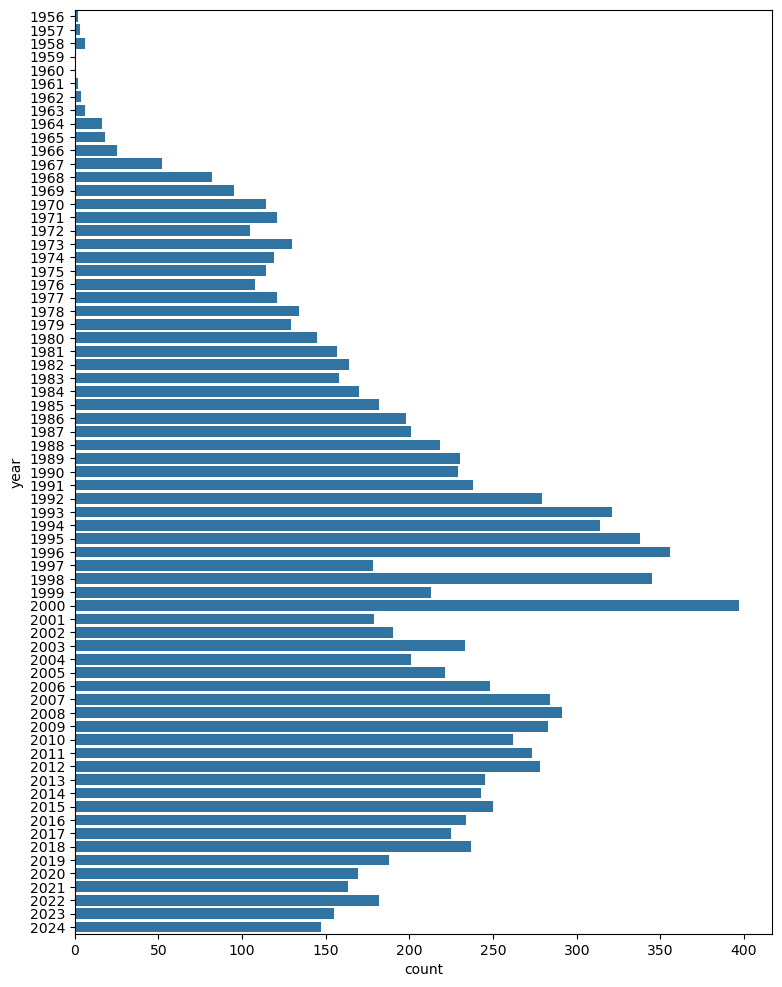

In [775]:
plt.figure(figsize=(9,12))
sns.countplot(data=df, y='year')

# **``df_uk_rock`` merge with ratings and cleaning**

In [258]:
# import the dataframes
df_blend_test = pd.read_csv('Datasets/df_blend_test.csv')                                 # df with the albums already cleaned
df_ratings_20 = pd.read_csv('Datasets/df_ratings_20.csv', keep_default_na=False)  # all ratings, mostly from rock, worldwide

# print information
print(f'{df_blend_test.shape}: df_blend_test')
print(f'{df_ratings_20.shape}: df_ratings_20')

(14300, 13): df_blend_test
(51252, 5): df_ratings_20


In [259]:
df_blend_test.head(1)

,artist_id,master_id,main_release_id,release_country,artist,title,year,album_length,tracks,release_type,genres,styles,artist_profile
0,15152368.0,3747909,31909420,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,"['LP', 'Album']",['Rock'],['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"


## Dropping columns

In [260]:
df_blend_test.release_type.value_counts().head()

release_type
['Album']                             5732
['LP', 'Album']                       4052
['LP', 'Album', 'Stereo']             1625
['LP', 'Album', 'Limited Edition']     545
['Album', 'Stereo']                    355
Name: count, dtype: int64

In [261]:
# I can drop it, as well as other columns
df_blend_test.drop(columns=['artist_id', 'master_id', 'main_release_id', 'release_type', 'genres'], inplace=True)
df_blend_test.head(1)

,release_country,artist,title,year,album_length,tracks,styles,artist_profile
0,NaN,As Living Arrows,Hope and Ruin,2024,0.0,8,['Post-Hardcore'],"Post-screamo band from Brighton, UK\r\n"


## Merge with ``df_ratings_top``

In [262]:
# print information
print(f'{df_blend_test.shape}: df_blend_test')
print(f'{df_ratings_20.shape}: df_ratings_20')

(14300, 8): df_blend_test
(51252, 5): df_ratings_20


In [263]:
df = pd.merge(
    df_ratings_20.assign(artist_lower=df_ratings_20['artist'].str.lower().str.strip(), 
                      title_lower=df_ratings_20['title'].str.lower().str.strip()), 
    df_blend_test.assign(artist_lower=df_blend_test['artist'].str.lower().str.strip(), 
                      title_lower=df_blend_test['title'].str.lower().str.strip()), 
    on=['artist_lower', 'title_lower']
).drop(columns=['artist_lower', 'title_lower', 'artist_y', 'title_y'])

# rename columns
df.rename(columns={'artist_x': 'artist', 'title_x': 'title'}, inplace=True)

# drop columns
df.drop(columns=['album_id'], inplace=True)

# print the shape
df.shape

(11159, 10)

In [264]:
df[df[['artist', 'title']].duplicated()]

,artist,title,rating,votes,release_country,year,album_length,tracks,styles,artist_profile
75,Led Zeppelin,Led Zeppelin,4.25,4088,UK,1969,39.75,9,"['Blues Rock', 'Hard Rock']",The English rock band Led Zeppelin was active ...
144,The Who,Tommy,4.08,1357,UK,1969,76.60,24,"['Rock Opera', 'Classic Rock']","English rock band formed in Hammersmith, Londo..."
187,Weezer,Weezer,4.36,4264,US,1994,41.30,10,"['Alternative Rock', 'Pop Rock', 'Pop Punk']","Rock band from Los Angeles, California, US.\r\..."
278,King Crimson,Larks' Tongues in Aspic,4.29,1603,UK,1973,46.62,6,"['Prog Rock', 'Experimental']",were an English-based progressive rock band fo...
301,Bob Dylan,Blood on the Tracks,4.45,1586,US,1975,51.67,10,"['Folk Rock', 'Acoustic', 'Ballad']","Born: May 24, 1941, Duluth, Minnesota, USA; si..."
...,...,...,...,...,...,...,...,...,...,...
9628,Toad,Toad,3.81,27,Italy,1971,0.00,7,['Hard Rock'],Swiss rock group.
10392,Panchiko,D>E>A>T>H>M>E>T>A>L,3.62,69,UK,2020,48.27,11,"['Indie Pop', 'Indie Rock']","Four-piece band from Nottingham, UK formed in ..."
10396,Jerry Garcia,Garcia,4.14,28,US,1972,40.07,10,"['Folk Rock', 'Psychedelic Rock']","Guitar, Banjo, pedal steel guitar and vocals.\..."
10916,Panchiko,D>E>A>T>H>M>E>T>A>L,3.79,29,UK,2020,48.27,11,"['Indie Pop', 'Indie Rock']","Four-piece band from Nottingham, UK formed in ..."


In [265]:
df[df.duplicated()]

,artist,title,rating,votes,release_country,year,album_length,tracks,styles,artist_profile
3421,Embrace,Embrace,3.99,309,Europe,2014,46.38,10,"['Indie Rock', 'Indie Pop']","English post-Britpop band from Bailiff Bridge,..."
3423,Embrace,Embrace,3.99,309,US,1987,0.00,14,"['Emo', 'Hardcore']","Embrace was short-lived band from Washington, ..."
3857,Drowning Pool,Drowning Pool,2.53,49,US,1987,0.00,9,"['Art Rock', 'Goth Rock', 'Avantgarde', 'Exper...",Drowning Pool was an avant-rock ensemble that ...
4713,Evanescence,Evanescence,3.46,75,UK & Europe,2011,47.28,12,['Alternative Rock'],Alternative Rock / Modern Rock band founded in...
6806,Drowning Pool,Drowning Pool,2.81,168,US,1987,0.00,9,"['Art Rock', 'Goth Rock', 'Avantgarde', 'Exper...",Drowning Pool was an avant-rock ensemble that ...
7903,Evanescence,Evanescence,3.13,502,UK & Europe,2011,47.28,12,['Alternative Rock'],Alternative Rock / Modern Rock band founded in...
9628,Toad,Toad,3.81,27,Italy,1971,0.00,7,['Hard Rock'],Swiss rock group.
10392,Panchiko,D>E>A>T>H>M>E>T>A>L,3.62,69,UK,2020,48.27,11,"['Indie Pop', 'Indie Rock']","Four-piece band from Nottingham, UK formed in ..."
10917,Panchiko,D>E>A>T>H>M>E>T>A>L,3.79,29,UK,2020,48.27,11,"['Indie Pop', 'Indie Rock']","Four-piece band from Nottingham, UK formed in ..."


In [48]:
df[df['title']=='Animal Tracks']

,year,artist,title,rating,votes,album_length,tracks,styles,release_country,artist_profile
4644,1965,The Animals,Animal Tracks,3.68,11,0.0,11,['Rhythm & Blues'],UK,British blues rock band formed in the early 19...
4645,1965,The Animals,Animal Tracks,3.60,10,0.0,11,['Rhythm & Blues'],UK,British blues rock band formed in the early 19...


In [52]:
df_ratings_top[df_ratings_top['title']=='Animal Tracks']

,album_id,artist,title,rating,votes
19213,30855,The Animals,Animal Tracks,3.68,11


In [50]:
df_ratings_top.shape

(79626, 5)

In [51]:
df_ratings_top.drop([19214], inplace=True)
df_ratings_top.shape

(79625, 5)

In [11]:
df.head()

,artist,title,rating,votes,release_country,year,album_length,tracks,styles,artist_profile
0,Sparta,Wiretap Scars,3.79,431,US,2002,47.62,12,"['Indie Rock', 'Alternative Rock']","El Paso, Texas based band. Formed in 2001 afte..."
1,Muse,Absolution,3.99,4411,Europe,2003,52.18,14,['Alternative Rock'],"Muse are an English rock band from Teignmouth,..."
2,Muse,Showbiz,3.50,2181,UK,1999,49.65,12,"['Alternative Rock', 'Prog Rock']","Muse are an English rock band from Teignmouth,..."
3,Finch,What It Is to Burn,3.69,864,US,2002,61.18,13,"['Emo', 'Post-Hardcore', 'Alternative Rock']","Finch is a post-hardcore band from Temecula, C..."
4,Transplants,Transplants,3.35,198,US,2002,45.23,12,['Punk'],"Punk rock/rap rock band Los Angeles, CA, Unite..."


## Sort columns

In [266]:
df.columns

Index(['artist', 'title', 'rating', 'votes', 'release_country', 'year',
       'album_length', 'tracks', 'styles', 'artist_profile'],
      dtype='object')

In [267]:
list_of_columns = ['year', 'artist', 'title', 'rating', 'votes', 'album_length', 'tracks', 'styles', 'release_country', 'artist_profile']
df = df.reindex(columns=list_of_columns)
df.head()

,year,artist,title,rating,votes,album_length,tracks,styles,release_country,artist_profile
0,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,"['Indie Rock', 'Alternative Rock']",US,"El Paso, Texas based band. Formed in 2001 afte..."
1,2003,Muse,Absolution,3.99,4411,52.18,14,['Alternative Rock'],Europe,"Muse are an English rock band from Teignmouth,..."
2,1999,Muse,Showbiz,3.50,2181,49.65,12,"['Alternative Rock', 'Prog Rock']",UK,"Muse are an English rock band from Teignmouth,..."
3,2002,Finch,What It Is to Burn,3.69,864,61.18,13,"['Emo', 'Post-Hardcore', 'Alternative Rock']",US,"Finch is a post-hardcore band from Temecula, C..."
4,2002,Queens of the Stone Age,Songs for the Deaf,4.26,4386,59.35,15,"['Stoner Rock', 'Hard Rock']",US,Alternative Rock/Stoner band formed in 1997 in...


In [268]:
# since there are still many artists from outside the UK, I will name it 'df_uk_rock_ratings' after merging with the locations and dropping these non-brittish artists
df.to_csv('Datasets/df_blend_ratings.csv', index=False)

# **Statistics**

In [3]:
# import the df
df = pd.read_csv('Datasets/df_rock_ratings.csv')
df.shape 

(12059, 10)

In [10]:
df.artist.nunique()

5095

In [4]:
# average number of votes
np.mean(df['votes'])

199.27423501119495

<Axes: xlabel='rating', ylabel='Count'>

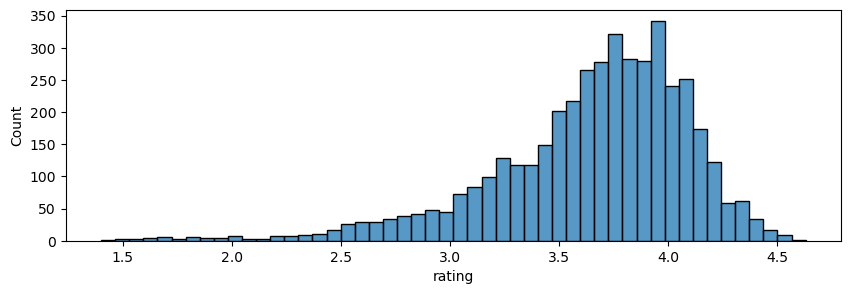

In [5]:
plt.figure(figsize=(10,3))
sns.histplot(data=df[df['votes']>100], x='rating')

<Axes: xlabel='votes', ylabel='Count'>

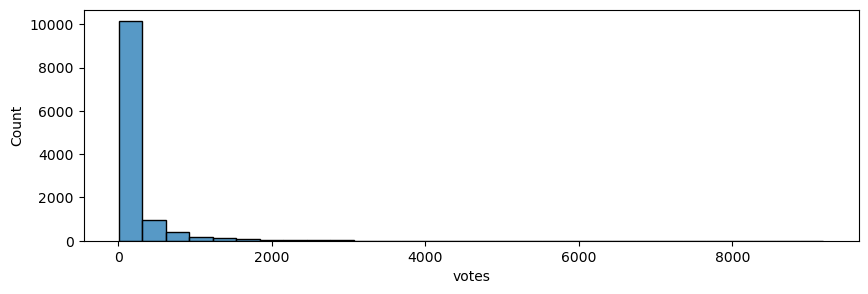

In [6]:
plt.figure(figsize=(10,3))
sns.histplot(data=df, x='votes', bins=30)

In [17]:
df[df['votes']>=20].shape

(9380, 10)

In [20]:
df[df['votes']>=20].artist.nunique()

3823

In [44]:
votes = 20

print(f"{df[df['votes']>=votes].shape[0]} of {df.shape[0]} albums have more than {votes} votes")
print(f"This represents {round(df[df['votes']>=votes].shape[0] / df.shape[0] *100, 2)} % of the albums")

9380 of 12059 albums have more than 20 votes
This represents 77.78 % of the albums


In [45]:
df_rock_ratings_20 = df[df['votes']>=20]
df_rock_ratings_20.shape

(9380, 10)

In [46]:
df_rock_ratings_20.head()

,year,artist,title,rating,votes,album_length,tracks,styles,release_country,artist_profile
0,2002,Sparta,Wiretap Scars,3.79,431,47.62,12,"['Indie Rock', 'Alternative Rock']",US,"El Paso, Texas based band. Formed in 2001 afte..."
1,2003,Muse,Absolution,3.99,4411,52.18,14,['Alternative Rock'],Europe,"Muse are an English rock band from Teignmouth,..."
2,1999,Muse,Showbiz,3.50,2181,49.65,12,"['Alternative Rock', 'Prog Rock']",UK,"Muse are an English rock band from Teignmouth,..."
3,2002,Finch,What It Is to Burn,3.69,864,61.18,13,"['Emo', 'Post-Hardcore', 'Alternative Rock']",US,"Finch is a post-hardcore band from Temecula, C..."
4,2002,Transplants,Transplants,3.35,198,45.23,12,['Punk'],US,"Punk rock/rap rock band Los Angeles, CA, Unite..."


In [47]:
df_rock_ratings_20.to_csv('Datasets/df_rock_ratings_20.csv', index=False)